In [1]:
from metric_learn.lmnn import LMNN
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(9999999)

In [2]:
# Load all of the saved files
train_feat = np.loadtxt('train_feat.gzip', dtype = 'float')
gallery_feat = np.loadtxt('gallery_feat.gzip', dtype = 'float')
query_feat = np.loadtxt('query_feat.gzip', dtype = 'float')
val_feat = np.loadtxt('val_feat.gzip', dtype = 'float')
train_noval_feat = np.loadtxt('train_noval_feat.gzip', dtype = 'float')
train_labels = np.loadtxt('train_labels.gzip', dtype = 'uint16')
gallery_labels = np.loadtxt('gallery_labels.gzip', dtype = 'uint16')
query_labels = np.loadtxt('query_labels.gzip', dtype = 'uint16')
val_labels = np.loadtxt('val_labels.gzip', dtype = 'uint16')
train_noval_labels = np.loadtxt('train_noval_labels.gzip', dtype = 'uint16')
#train_filelist = np.loadtxt('train_filelist.gzip', dtype = 'uint16')
#gallery_filelist = np.loadtxt('gallery_filelist.gzip', dtype = 'uint16')
#query_filelist = np.loadtxt('query_filelist.gzip', dtype = 'uint16')
#val_filelist = np.loadtxt('val_filelist.gzip', dtype = 'uint16')
#train_noval_filelist = np.loadtxt('train_noval_filelist.gzip', dtype = 'uint16')
train_camId = np.loadtxt('train_camId.gzip', dtype = 'uint16') # uint8
gallery_camId = np.loadtxt('gallery_camId.gzip', dtype = 'uint16')
query_camId = np.loadtxt('query_camId.gzip', dtype = 'uint16')
val_camId = np.loadtxt('val_camId.gzip', dtype = 'uint16')
train_noval_camId = np.loadtxt('train_noval_camId.gzip', dtype = 'uint16')

In [3]:
#Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)
print(val_pair_unique, val_pair_unique_indxs, val_pair_unique.shape)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

print(val_feat.shape, val_labels.shape)
print(val_query_feat.shape, val_query_labels.shape, val_query_camId.shape, val_gallery_feat.shape, val_gallery_labels.shape, val_gallery_camId.shape)


[[   2    2    8 ... 1466 1467 1467]
 [   1    2    1 ...    2    1    2]] [   0    5   10 ... 5749 5754 5759] (2, 1199)
(5764, 2048) (5764,)
(1190, 2048) (1190,) (1190,) (4574, 2048) (4574,) (4574,)


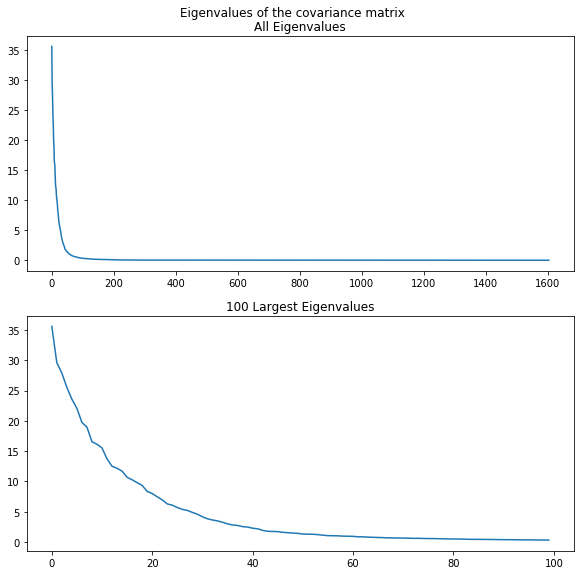

Percentage of total data variance captured: 0.9962195660564382


In [4]:
#DO PCA
pca_train_noval =PCA()
pca_train_noval.fit(train_noval_feat)
pca_train_noval_eigvals = pca_train_noval.explained_variance_

x = np.arange(0, pca_train_noval_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_noval_eigvals, '-')
axs[0].set_title('All Eigenvalues')

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_noval_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
plt.show()

print("Percentage of total data variance captured:", 
      (np.sum(pca_train_noval_eigvals[:500]))/(np.sum(pca_train_noval_eigvals[:500])+np.sum(pca_train_noval_eigvals[500:])))

In [5]:
pca = PCA(n_components=500)
train_noval_feat_reduced = pca.fit_transform(train_noval_feat)

In [6]:
# Create a dict storing the differently transformed features
feat_dict = {}
feat_dict["basecase"] = (val_query_feat, val_gallery_feat)

In [ ]:
M = LMNN(verbose=True).fit(train_noval_feat,train_noval_labels)
val_query_feat_M = M.transform(val_query_feat)
val_gallery_feat_M = M.transform(val_gallery_feat)

feat_dict["LMNN"]=(val_query_feat_M,val_gallery_feat_M)

/Users/paulstreli/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


In [19]:
M_reduced = LMNN(verbose=True).fit(train_noval_feat_reduced,train_noval_labels)

val_query_feat_reduced = pca.transform(val_query_feat)
val_gallery_feat_reduced = pca.transform(val_gallery_feat)
print(val_query_feat_reduced.shape, val_gallery_feat_reduced.shape)

val_query_feat_M_reduced = M_reduced.transform(val_query_feat_reduced)
val_gallery_feat_M_reduced = M_reduced.transform(val_gallery_feat_reduced)

feat_dict["LMNN reduced"]=(val_query_feat_M_reduced,val_gallery_feat_M_reduced)

(191, 500) (765, 500)


In [7]:
# Function that takes as input an index that refers to a query image
# and returns the val_gallery without the unnecessary pictures in it
# Remove the pictures from the gallery that have the same label and are taken by the same camera as out VAL_QUERY[index]
# picture in the query array
def get_removed_val_gallery (index, t_gallery_feat):
    selected_indices = np.logical_not(np.logical_and(val_gallery_camId == val_query_camId[index], val_gallery_labels == val_query_labels[index]))
    return t_gallery_feat[selected_indices, :], val_gallery_labels[selected_indices], val_gallery_camId[selected_indices]

In [8]:
for key, (t_query_feat, t_gallery_feat) in feat_dict.items():
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((val_query_labels.shape[0],k))

    for i in range (0, val_query_labels.shape[0], 1):
        gallery_feat_removed, gallery_labels_removed, gallery_camId_removed = get_removed_val_gallery (i, t_gallery_feat)
        nbrs = NearestNeighbors(n_neighbors=k).fit(gallery_feat_removed)
        distances, indices = nbrs.kneighbors(t_query_feat[i:i+1, :])
        print(gallery_labels_removed[indices], val_query_labels[i])
        print("camIds:", gallery_camId_removed[indices], val_query_camId[i])
        is_same_label = (val_query_labels[i] == gallery_labels_removed[indices])
    
        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[0, :(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[0, :(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[0, :(j+1)])/np.sum(gallery_labels_removed==val_query_labels[i])

    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print ("Mean average precision:", average_precisions.mean())
    

[[  2   2   2   2 844 844 844  29 844 188]] 2
camIds: [[2 2 2 2 2 2 1 1 1 1]] 1
[[  2   2   2   2  29 844 844 844 844 844]] 2
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[   8    8    8    8 1395  855  855  855  855  512]] 8
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[  8   8   8   8 855 855 855 855 855 855]] 8
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[  9   9   9   9 712 712 395 712 712 395]] 9
camIds: [[2 2 2 2 2 1 1 1 1 2]] 1
[[  9   9   9   9 167 395 116 395 395 167]] 9
camIds: [[1 1 1 1 2 1 2 2 1 2]] 2
[[10 10 10 10 65 59 59 59 65 65]] 10
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[ 10  10  10  10  65  65  65  65 685  59]] 10
camIds: [[1 1 1 1 2 2 2 1 1 1]] 2
[[12 12 12 12 13 13 13 23 13 13]] 12
camIds: [[2 2 2 2 1 1 2 1 1 1]] 1
[[ 12  12  12  12  23  23  23  23 253  13]] 12
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[13 13 13 13 19 19 19 19 23 19]] 13
camIds: [[2 2 2 2 1 1 1 1 1 2]] 1
[[13 13 13 13 19 19 19 19 23 23]] 13
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[ 16  16  16  16  16 656 656 268 656 656]] 16
camIds: [[1 1 1 1

[[122 122 122 122 383 383 466 601 383 567]] 122
camIds: [[2 2 2 2 2 2 1 1 2 2]] 1
[[122 122 122 122 466 470 680 680 680 680]] 122
camIds: [[1 1 1 1 1 2 2 1 2 1]] 2
[[124 124 124 124 308 583 308 308 583 583]] 124
camIds: [[2 2 2 2 1 1 2 2 1 1]] 1
[[ 124  124  124  124 1051 1051 1051  498 1051 1325]] 124
camIds: [[1 1 1 1 2 1 2 1 2 2]] 2
[[ 125  125  125  125 1202  420  420  602  602 1202]] 125
camIds: [[2 2 2 2 2 1 1 1 1 2]] 1
[[ 125  125  125  125  392  582  577  618  582 1244]] 125
camIds: [[1 1 1 1 1 1 2 2 2 2]] 2
[[126 126 126 126 589 589 589 330 168 589]] 126
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[126 126 126 126  57  57  57  57 168 168]] 126
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[130 130 130 130 992 371 226 226 992 371]] 130
camIds: [[2 2 2 2 1 2 2 2 1 1]] 1
[[130 130 130 130 608 992 347 992 992 226]] 130
camIds: [[1 1 1 1 2 1 2 1 1 2]] 2
[[137 137 137 137 274 225 225 225 274 225]] 137
camIds: [[2 2 2 2 1 1 1 2 1 1]] 1
[[137 137 137 137 538 538 492 538 428 538]] 137
camIds: [[1 1 1 1 2 

[[253 253 253 253 204 204 204 204 204 204]] 253
camIds: [[1 1 1 1 2 2 1 2 2 1]] 2
[[260 260 260 260 701 342 342  18 515 342]] 260
camIds: [[2 2 2 2 2 2 2 1 1 1]] 1
[[260 260 260 260 701 729 312 701 842 842]] 260
camIds: [[1 1 1 1 2 2 1 2 2 2]] 2
[[262 262 262 262 847 579 480 847 579 264]] 262
camIds: [[2 2 2 2 1 1 2 2 1 1]] 1
[[262 262 262 262 480 480 480 847 480 480]] 262
camIds: [[1 1 1 1 2 1 2 2 1 2]] 2
[[263 263 263 263 368 302  75 368 368 368]] 263
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[ 263  263  263  263  416  368  302   75  302 1306]] 263
camIds: [[1 1 1 1 2 1 1 1 2 1]] 2
[[264 264 264 161 161 161 262 262 262 161]] 264
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[ 264  264  264  264  383  383  383  383 1035 1035]] 264
camIds: [[1 1 1 1 2 2 2 2 1 1]] 2
[[ 268  268  268  268 1235 1235  297   16   16 1235]] 268
camIds: [[2 2 2 2 2 2 2 1 1 2]] 1
[[ 268  268  268  268  297  297  297  297  656 1383]] 268
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[272 272 272 272 641 582 641 641 641 139]] 272
camIds: [[

[[371 371 371 371 580 580 608 553 608 608]] 371
camIds: [[2 2 2 2 2 2 1 1 1 1]] 1
[[ 371  371  371  608  608  580  130  608  608 1115]] 371
camIds: [[1 1 1 1 1 2 1 1 2 2]] 2
[[377 377 298 433 433 433 298 298  10 433]] 377
camIds: [[2 2 1 2 2 2 1 1 2 2]] 1
[[377 377 377 298 298 298 298 298 298 298]] 377
camIds: [[1 1 1 1 2 1 1 1 2 2]] 2
[[380 380 380 380 765 765 318 318 318 765]] 380
camIds: [[2 2 2 2 2 2 1 2 2 1]] 1
[[380 380 380 380 318 765 765 318 641 765]] 380
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[ 383  383  383  383 1401 1401  264  122 1143  264]] 383
camIds: [[2 2 2 2 2 2 1 1 2 2]] 1
[[383 383 383 383 122 632 264 386 386 264]] 383
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[385 385 385 385 728 728 728 297 728 728]] 385
camIds: [[2 2 2 2 1 1 1 1 1 2]] 1
[[385 385 385 385 302 535 297 713 192 260]] 385
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[386 386 386 386 587 587 587 567 644 567]] 386
camIds: [[2 2 2 2 2 2 1 1 1 2]] 1
[[386 386 386 386 644 383 644 383 383 535]] 386
camIds: [[1 1 1 1 1 1 1 2 2 2]

[[492 492 492 492 462 472 387 472 462 472]] 492
camIds: [[2 2 2 2 2 1 1 2 1 1]] 1
[[ 492  492  492  492 1208  387  538  486 1208  137]] 492
camIds: [[1 1 1 1 2 1 1 1 2 1]] 2
[[ 493  493  493  493 1414  289  667 1414  117  667]] 493
camIds: [[2 2 2 2 2 1 1 1 1 1]] 1
[[ 493  493  493  493  117  117  117  117  117 1414]] 493
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[495 495 495 495 478  95  20  95  20  20]] 495
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[495 495 495 495 618 618  95 808  95 808]] 495
camIds: [[1 1 1 1 2 1 2 2 2 2]] 2
[[497 497 497 497 513 693  73 567 693 377]] 497
camIds: [[2 2 2 2 1 1 2 1 2 1]] 1
[[497 497 497 497 513 513 513 513 513 513]] 497
camIds: [[1 1 1 1 2 2 2 1 2 1]] 2
[[498 498 498 498 658 658 658 658  36 604]] 498
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[498 498 498 498 658 658 658 124 604 658]] 498
camIds: [[1 1 1 1 2 2 2 2 1 2]] 2
[[500 500 500 500 456 456 456 456 192 486]] 500
camIds: [[2 2 2 2 1 2 1 2 2 1]] 1
[[ 500  500  500  500  535  192  192  468  468 1403]] 500
camIds: [[

[[612 612 612 612 637  71 631 501 637 788]] 612
camIds: [[2 2 2 2 1 2 1 1 2 2]] 1
[[ 612  612  612  612  766  637  766 1084  766  629]] 612
camIds: [[1 1 1 1 1 1 2 1 2 2]] 2
[[ 613  613  613  613 1416 1416 1416  138  428  138]] 613
camIds: [[2 2 2 2 2 2 2 1 2 1]] 1
[[ 613  613  613  613 1416 1416 1416 1416 1416 1416]] 613
camIds: [[1 1 1 1 2 2 2 1 2 1]] 2
[[615 615 615 615 659 659 327 759 659 728]] 615
camIds: [[2 2 2 2 1 1 2 2 1 2]] 1
[[615 615 615 615 728 199 199 728 327 659]] 615
camIds: [[1 1 1 1 2 1 1 2 2 1]] 2
[[617 617 617 617 169 169 821 664 169 169]] 617
camIds: [[2 2 2 2 2 2 1 1 1 2]] 1
[[617 617 617 617 169 169 766 766 766 169]] 617
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[618 618 618 618  95  95  20 125  61 125]] 618
camIds: [[2 2 2 2 2 1 1 2 1 2]] 1
[[ 618  618  618  618 1292   61   95   20 1292   61]] 618
camIds: [[1 1 1 1 2 1 2 1 2 2]] 2
[[619 619 619 619 191 688 191 191 363 191]] 619
camIds: [[2 2 2 2 1 2 2 2 2 2]] 1
[[619 619 619 619 191 363 363 191 688 191]] 619
camIds: [[

[[728 728 728 728 283 283 615 615 684 283]] 728
camIds: [[1 1 1 1 2 2 1 2 2 2]] 2
[[729 729 729 729 631 631 387 387 387 387]] 729
camIds: [[2 2 2 2 2 1 2 1 1 2]] 1
[[729 729 729 729 677 688 688 688 688 787]] 729
camIds: [[1 1 1 1 2 2 1 1 1 2]] 2
[[731 731 731 731  83  83 768  83 768  83]] 731
camIds: [[2 2 2 2 2 2 2 1 2 1]] 1
[[ 731  731  731  731 1034   83  274 1034 1034  561]] 731
camIds: [[1 1 1 1 2 2 2 2 1 2]] 2
[[ 733  733  733  733 1304  608  608 1304 1304 1304]] 733
camIds: [[2 2 2 2 1 1 1 2 2 2]] 1
[[ 733  733  733  733 1024  778  778  483 1304 1304]] 733
camIds: [[1 1 1 1 2 1 2 1 2 2]] 2
[[734 734 734 734 141 141 234 234   9   9]] 734
camIds: [[2 2 2 2 1 1 2 1 2 2]] 1
[[734 734 734 734 234 630 234 141 141  12]] 734
camIds: [[1 1 1 1 2 1 1 1 1 1]] 2
[[ 735  735  735  735 1362 1362 1420 1362 1362 1420]] 735
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[735 735 735 735 264 264 741 264 791 741]] 735
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[737 737 737 737 456 456 456 295 456 456]] 737
camIds: [[

[[ 848  848  848  848  878  878 1275  878 1275  878]] 848
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[ 852  852  852  852  857  857 1327  977 1327  857]] 852
camIds: [[2 2 2 2 1 2 2 2 2 2]] 1
[[ 852  852  852  852 1327 1327 1327  906  906 1327]] 852
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[ 855  855  855  855    8    8    8 1395    8 1395]] 855
camIds: [[2 2 2 2 1 1 1 2 2 2]] 1
[[855 855 855 855   8   8   8   8   8   8]] 855
camIds: [[1 1 1 1 2 1 1 2 1 2]] 2
[[857 857 857 857   9   9   9   9   9 262]] 857
camIds: [[2 2 2 2 2 1 2 1 1 2]] 1
[[ 857  857  857  857 1374  852 1260  847 1374 1260]] 857
camIds: [[1 1 1 1 2 1 1 2 2 2]] 2
[[ 861  861  861  861  810   10   10   10 1281   10]] 861
camIds: [[2 2 2 2 1 2 2 2 1 2]] 1
[[ 861  861  861  861  810 1268   10   10   10   10]] 861
camIds: [[1 1 1 1 1 1 2 2 2 1]] 2
[[ 867  867  867  867 1158 1158 1158 1158 1158  900]] 867
camIds: [[2 2 2 2 2 2 2 2 1 2]] 1
[[867 867 867 867 906 906 906 906 890 906]] 867
camIds: [[1 1 1 1 2 2 2 1 1 1]] 2
[[876 876 876 876 

[[1000 1000 1000 1000 1427 1427 1085 1427 1084 1427]] 1000
camIds: [[2 2 2 2 1 1 2 1 2 2]] 1
[[1000 1000 1000 1084 1084 1279 1085 1427 1084 1136]] 1000
camIds: [[1 1 1 2 1 2 2 1 2 2]] 2
[[1001 1001 1001 1001  961  984  984 1060  984  984]] 1001
camIds: [[2 2 2 2 2 2 2 1 1 2]] 1
[[1001 1001 1001 1001  961  984 1060  961  984  961]] 1001
camIds: [[1 1 1 1 2 2 1 2 2 1]] 2
[[1003 1003 1003 1003 1024 1156  997 1076 1272 1024]] 1003
camIds: [[2 2 2 2 1 1 2 2 1 1]] 1
[[1003 1003 1003 1003 1076  997 1083  169  169 1109]] 1003
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[1006 1006 1006 1006  935  935  935  935  935  935]] 1006
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[1006 1006 1006 1006  935  138 1229 1246 1246  138]] 1006
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[1012 1012 1012 1012 1040 1040 1040  776  139 1040]] 1012
camIds: [[2 2 2 2 2 1 2 1 2 1]] 1
[[1012 1012 1012 1012 1152 1253 1210 1152 1210 1253]] 1012
camIds: [[1 1 1 1 1 2 2 2 2 2]] 2
[[1015 1015 1015 1015 1275 1169  957  122 1035 1035]] 1015
camIds: [[2

[[1113 1113 1113 1113  199 1269 1269  500 1236 1269]] 1113
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[1115 1115 1115 1115 1080  987  987 1080 1090 1090]] 1115
camIds: [[2 2 2 2 2 1 1 2 1 1]] 1
[[1115 1115 1115 1115  987  987  987  987  987 1080]] 1115
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[1118 1118 1118 1118 1036 1039  890  890  430  430]] 1118
camIds: [[2 2 2 2 1 2 1 1 2 2]] 1
[[1118 1118 1118 1118 1039 1039 1039  430  430  430]] 1118
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[1129 1129 1129 1129 1275 1275 1254 1275 1275 1275]] 1129
camIds: [[2 2 2 2 1 1 1 2 2 1]] 1
[[1129 1129 1129 1129  952 1254 1275 1254 1060 1018]] 1129
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[1130 1130 1130 1130 1151 1151 1208 1208 1053  986]] 1130
camIds: [[2 2 2 2 2 1 2 1 1 2]] 1
[[1130 1130 1130 1130 1208 1208 1080 1115  986 1208]] 1130
camIds: [[1 1 1 1 1 2 2 2 2 1]] 2
[[1135 1135 1135 1135 1260 1400 1258 1400 1260 1029]] 1135
camIds: [[2 2 2 2 1 2 2 2 1 1]] 1
[[1135 1135 1135 1135 1073 1073 1073 1400 1400 1073]] 1135
camIds: [[1

[[1219 1219 1219 1219  844 1215 1260 1235  957 1215]] 1219
camIds: [[2 2 2 2 2 1 2 2 2 1]] 1
[[1219 1219 1219 1219  141 1260  992 1211  844  734]] 1219
camIds: [[1 1 1 1 1 2 2 2 2 1]] 2
[[1229 1229 1229 1229 1006 1006  985  985  985 1092]] 1229
camIds: [[2 2 2 2 2 2 1 1 1 1]] 1
[[1229 1229 1229 1229  978 1215 1092 1092 1215  978]] 1229
camIds: [[1 1 1 1 2 2 1 2 1 2]] 2
[[1231 1231 1231 1231  985 1154 1196 1196 1167 1154]] 1231
camIds: [[2 2 2 2 1 2 1 1 1 1]] 1
[[1231 1231 1231 1231  985 1154 1154 1154  896 1154]] 1231
camIds: [[1 1 1 1 1 1 2 2 2 1]] 2
[[1235 1235 1235 1235 1339 1339 1219 1219 1089 1339]] 1235
camIds: [[2 2 2 2 2 1 1 1 1 2]] 1
[[1235 1235 1235 1235 1089 1339 1244 1219 1244 1219]] 1235
camIds: [[1 1 1 1 1 2 2 1 1 1]] 2
[[1236 1236 1236 1236 1249 1249  914  914 1249 1249]] 1236
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[1236 1236 1236 1236 1249 1249 1249  914  914 1272]] 1236
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[1237 1237 1237 1237 1282  833 1282 1282  833 1282]] 1237
camIds: [[2

[[1314 1314 1314  583  604  583  604 1316 1430  604]] 1314
camIds: [[1 1 1 1 2 1 2 2 2 2]] 2
[[1315 1315 1315 1315 1320 1320 1447 1447 1447 1447]] 1315
camIds: [[2 2 2 2 2 2 1 2 1 2]] 1
[[1315 1315 1315 1315  701 1320  252  701  252  701]] 1315
camIds: [[1 1 1 1 2 2 2 1 2 1]] 2
[[1316 1316 1316 1316 1316  108  830  108 1433 1314]] 1316
camIds: [[2 2 2 2 2 1 2 2 1 2]] 1
[[1318 1318 1318 1318 1303 1308 1303 1303 1339 1306]] 1318
camIds: [[2 2 2 2 2 1 2 2 2 1]] 1
[[1318 1318 1318 1318 1303 1303 1327  588  588 1339]] 1318
camIds: [[1 1 1 1 2 2 2 2 1 2]] 2
[[1320 1320 1320 1320 1357 1357 1357 1284 1284  828]] 1320
camIds: [[2 2 2 2 1 2 1 1 1 2]] 1
[[1320 1320 1320 1320 1357 1357 1357 1357  828  828]] 1320
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[1323 1323 1323 1337 1337 1337 1290 1290 1337  385]] 1323
camIds: [[2 2 2 1 1 1 1 1 2 2]] 1
[[1323 1323 1245 1287 1290 1287 1290 1314 1290 1290]] 1323
camIds: [[1 1 1 2 1 2 1 2 2 2]] 2
[[1325 1325 1325 1399 1051 1357 1275  914 1401 1399]] 1325
camIds: [[2

[[1410 1410 1410 1410  848  848  848  819  848  819]] 1410
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[1413 1413 1413 1413  312 1458  312 1458  188  188]] 1413
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[1413 1413 1413 1413  910 1458 1458  312 1458 1281]] 1413
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[1414 1414 1414 1414 1403 1403  493 1403 1403 1402]] 1414
camIds: [[2 2 2 2 1 1 1 1 1 2]] 1
[[1414 1414 1414 1403 1260 1403 1260  806 1403  845]] 1414
camIds: [[1 1 1 2 2 2 2 1 1 2]] 2
[[1416 1416 1416 1416  613  613  613 1378  613  613]] 1416
camIds: [[2 2 2 2 1 2 2 1 2 2]] 1
[[1416 1416 1416 1416 1196  613  613  613  613  613]] 1416
camIds: [[1 1 1 1 1 2 2 1 2 2]] 2
[[1417 1417 1417 1460 1460 1460 1460 1460 1460 1460]] 1417
camIds: [[2 2 2 2 1 2 2 2 1 1]] 1
[[1417 1417 1417 1460 1460  867 1460 1402 1402 1460]] 1417
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[1419 1419 1361 1361 1361  906 1361 1361 1361  867]] 1419
camIds: [[2 2 1 2 1 1 1 1 2 1]] 1
[[1419 1419 1419 1419  906  906  906 1361  906  906]] 1419
camIds: [[1

In [11]:
print(2 not in [3,4])

True
